## Import libraries and read data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path
from rdkit import Chem

In [2]:
HERE = Path(_dh[-1])
DATA_PATH = HERE.parent.parent/'model_creation'/'data'/'fda_approved'
drugs_padel = pd.read_csv(DATA_PATH/'fda_padel_pre_processed_descriptors_no_inputation.csv')
drugs_padel

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,6.560927,6.732051,1.683013,6.732051,0.000000,6.732051e+00,9.0,0.0,-0.646,12.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,7.503203,8.696802,1.739360,7.228927,4.642168,2.586760e+00,18.0,2.0,-0.728,16.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,8.447475,8.696802,1.739360,9.541980,4.642168,4.899812e+00,18.0,2.0,-1.606,16.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,7.002720,6.871320,1.717830,4.621320,0.000000,2.310660e+00,10.0,1.0,0.106,10.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,7.801394,6.732051,1.683013,4.976068,2.244017,8.881784e-16,9.0,0.0,-0.786,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882,SOMAPACITAN,CHEMBL3707290,C=C(CCCCCCCCCCCCCCCc1nnn[nH]1)NS(=O)(=O)CCCC(=...,2020,NaN,Small molecule,False,True,False,False,...,7.030358,174.605498,1.961860,92.929028,48.841791,3.772568e+01,89341.0,106.0,-0.529,394.0
1883,PAFOLACIANINE,CHEMBL4297412,CC1(C)C(/C=C/C2=C(Oc3ccc(C[C@H](NC(=O)c4ccc(NC...,2021,PAFOLACIANINE SODIUM,Small molecule,False,True,False,False,...,8.341897,184.607801,2.028657,82.773199,41.626767,2.817620e+01,55718.0,157.0,2.248,498.0
1884,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,7.858439,191.117705,1.990809,113.557567,55.593680,4.880983e+01,62651.0,159.0,-8.139,488.0
1885,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,7.551281,207.741843,1.941513,132.687639,68.301850,4.833504e+01,76304.0,151.0,-4.197,510.0


## Separate datasets

In [3]:
response_variables = drugs_padel.iloc[:, :14]
print(f'response_variables: {response_variables.columns} and its shape {response_variables.shape}')

padel_descriptors = drugs_padel.iloc[:,14:]
print(f'\nSome descriptors columns: {padel_descriptors.columns} and its shape {padel_descriptors.shape}')

response_variables: Index(['name', 'chembl_id', 'clean_smiles', 'first_approval_year',
       'indication_class', 'molecule_type', 'withdrawn_flag',
       'therapeutic_flag', 'polymer_flag', 'inorganic_flag',
       'natural_product_flag', 'parenteral', 'topical', 'oral'],
      dtype='object') and its shape (1887, 14)

Some descriptors columns: Index(['ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond', 'nAtom',
       'nHeavyAtom', 'nH', 'nB',
       ...
       'AMW', 'WTPT-1', 'WTPT-2', 'WTPT-3', 'WTPT-4', 'WTPT-5', 'WPATH',
       'WPOL', 'XLogP', 'Zagreb'],
      dtype='object', length=1219) and its shape (1887, 1219)


### Double check for missing values

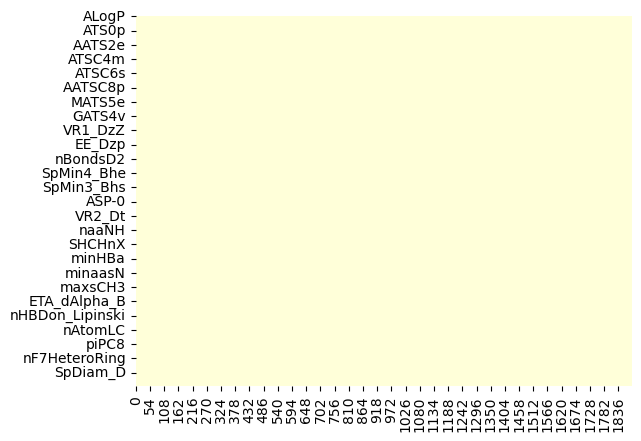

In [4]:
missing_values_heatmap = sns.heatmap(padel_descriptors.isna().transpose(), cmap='YlGnBu', cbar=False)

### Variable to float

Every descriptor must be coerced to float number so the following steps are done adequately.

In [5]:
padel_descriptors = padel_descriptors.astype(float)
padel_descriptors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Columns: 1219 entries, ALogP to Zagreb
dtypes: float64(1219)
memory usage: 17.5 MB


## PCA

### Generate PCA data

In [6]:
# X matrix
X_padel = padel_descriptors.copy()

# Scaling/normalizing data
scaler = StandardScaler()
X_padel_scaled = scaler.fit_transform(X_padel)

# Principal Component Analysis
pca = PCA(n_components=15)
pca_padel = pca.fit_transform(X_padel_scaled)

In [7]:
# Labels
labels_mapping = {
    'oral': ['non oral', 'oral'],
    'natural_product_flag': ['synthetic', 'natural'],
    'topical': ['other', 'topical']
}

# Function to generate legend for the plot
def create_legend_labels(column_name):
    return [labels_mapping[column_name][point] for point in response_variables[column_name]]

legend_oral = create_legend_labels('oral')
legend_np = create_legend_labels('natural_product_flag')
legend_topical = create_legend_labels('topical')

In [8]:
# Data conversion to dataframe
data = {
    'pc1':pca_padel[:,0],
    'pc2':pca_padel[:,1],
    'pc3':pca_padel[:,2],
    'legend_oral':legend_oral,
    'legend_np':legend_np,
    'legend_topical':legend_topical 
} 
pca_df = pd.DataFrame(data)

### Plot data

Text(0.5, 0.98, 'Chemical Space using PCA for PaDeL Descriptors')

<Figure size 640x480 with 0 Axes>

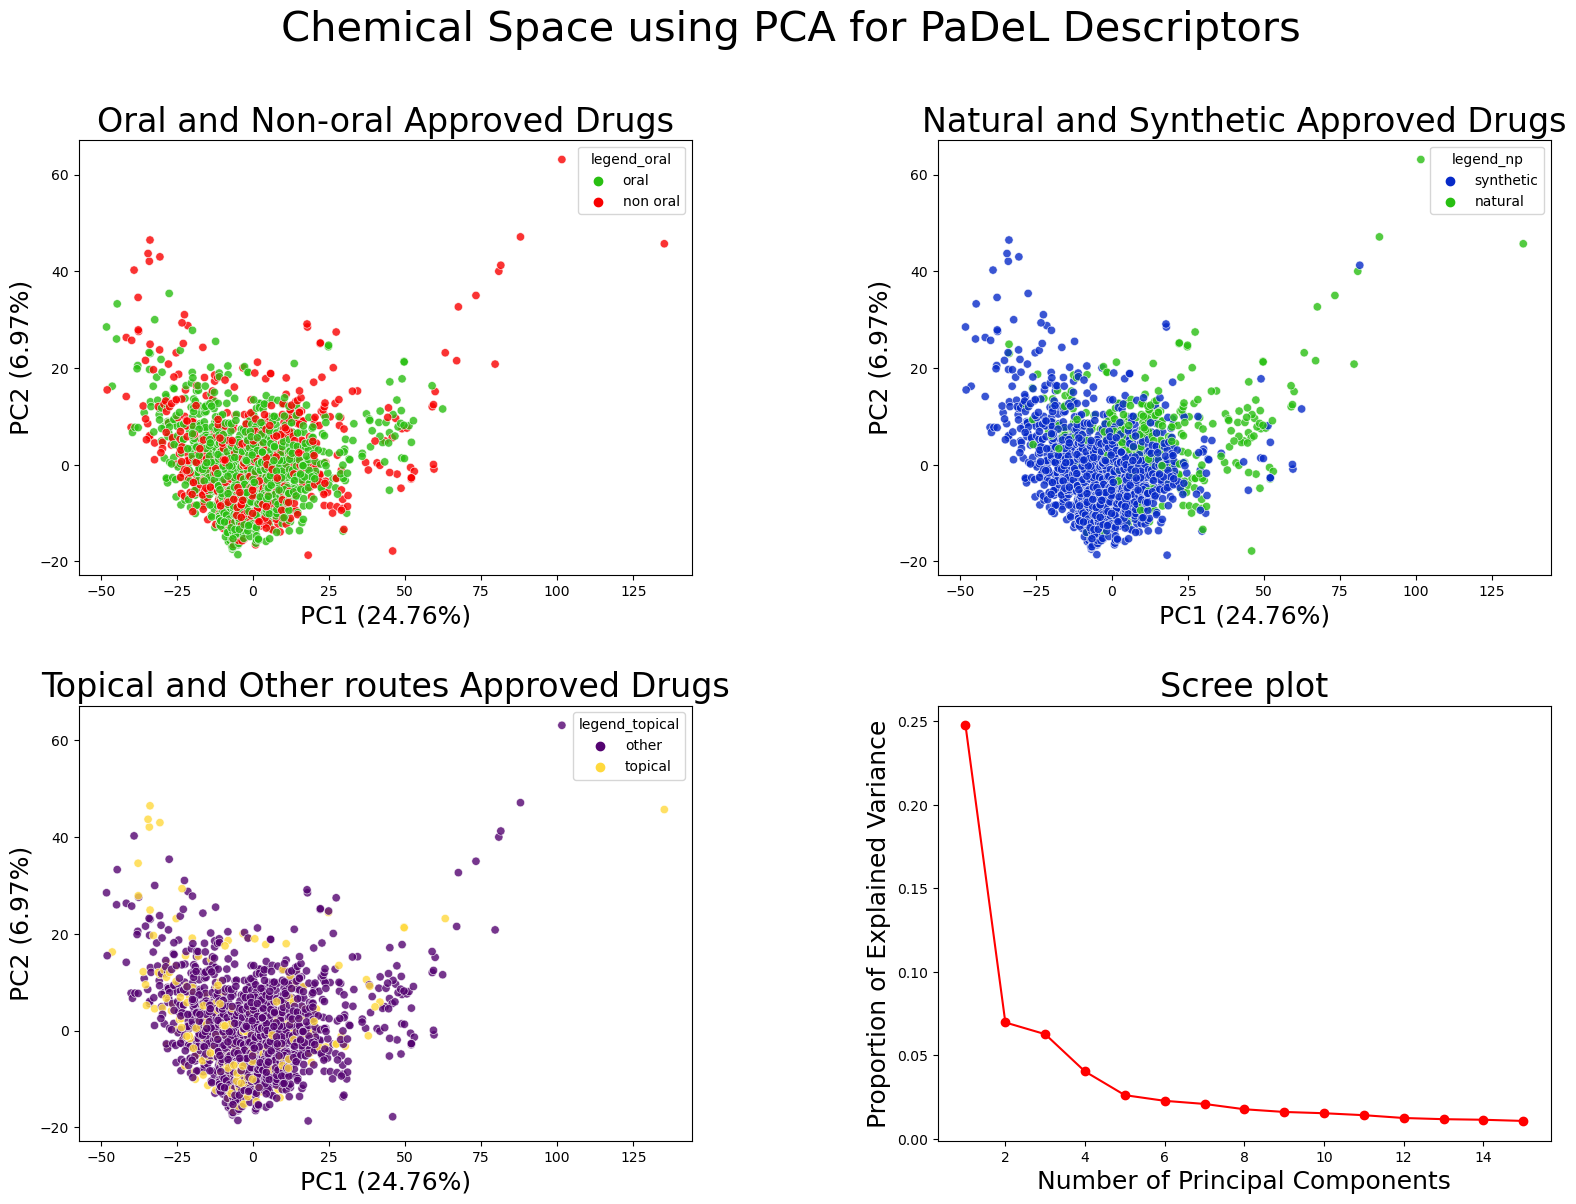

In [9]:
# PCA plots for oral/non oral, natural/synthetic and topical/other routes drugs
VAR_PC1 = round(list(pca.explained_variance_ratio_)[0]*100, 2)
VAR_PC2 = round(list(pca.explained_variance_ratio_)[1]*100, 2)
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
n_rows, n_cols = 2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(19,13))

palettes = {
    'oral': {'oral': '#29bf12', 'non oral': '#f90000'},
    'np': {'synthetic': '#072ac8', 'natural': '#28bf12'},
    'topical': {'topical': '#FFD93d', 'other':'#540371'}
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'np': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

# PCA plots
for i, category in enumerate(['oral', 'np', 'topical']):
    row = i // n_cols
    col = i % n_cols

    sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue=f'legend_{category}', ax=axs[row][col],
    palette=palettes[category], alpha=0.8)
    axs[row][col].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[row][col].set_xlabel(f'PC1 ({VAR_PC1}%)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[row][col].set_ylabel(f'PC2 ({VAR_PC2}%)',fontsize=AXIS_LABEL_FONT_SIZE)

# Scree plot
PC_values = np.arange(pca.n_components_) + 1
axs[1][1].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1][1].set_title('Scree plot', fontsize=TITLE_FONT_SIZE)
axs[1][1].set_xlabel('Number of Principal Components', fontsize=AXIS_LABEL_FONT_SIZE)
axs[1][1].set_ylabel('Proportion of Explained Variance', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.suptitle('Chemical Space using PCA for PaDeL Descriptors', fontsize=30)

### Domain-knowledge interpretation of components

## t-SNE

### Perform t-SNE, merge data

In [10]:
# X matrix
X_padel = padel_descriptors

# Scaling/normalizing data
scaler = StandardScaler()
X_padel_scaled = scaler.fit_transform(X_padel)

# PCA to reduce dimensionality
pca_30 = PCA(n_components=30)
pca_30_results = pca_30.fit_transform(X_padel_scaled)

# t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=70, n_iter=1000)
tsne_results = tsne.fit_transform(pca_30_results)

In [11]:
# Defining the labels
labels_mapping = {
    'oral': ['non oral', 'oral'],
    'natural_product_flag': ['synthetic', 'natural'],
    'topical': ['other', 'topical']
}

def create_legend_labels(column_name):
    return [labels_mapping[column_name][point] for point in response_variables[column_name]]

legend_oral = create_legend_labels('oral')
legend_np = create_legend_labels('natural_product_flag')
legend_topical = create_legend_labels('topical')

In [12]:
# Data dict and conversion to dataframe
data = {
    'tsne2d_1': tsne_results[:,0],
    'tsne2d_2': tsne_results[:,1],
    'legend_oral': legend_oral,
    'legend_np': legend_np,
    'legend_topical': legend_topical,
}
tsne_df = pd.DataFrame(data)

### Plot t-SNE

Text(0.5, 0.98, 'Chemical Space Visualization of FDA Approved Drugs \n(PaDeL Descriptors)')

<Figure size 640x480 with 0 Axes>

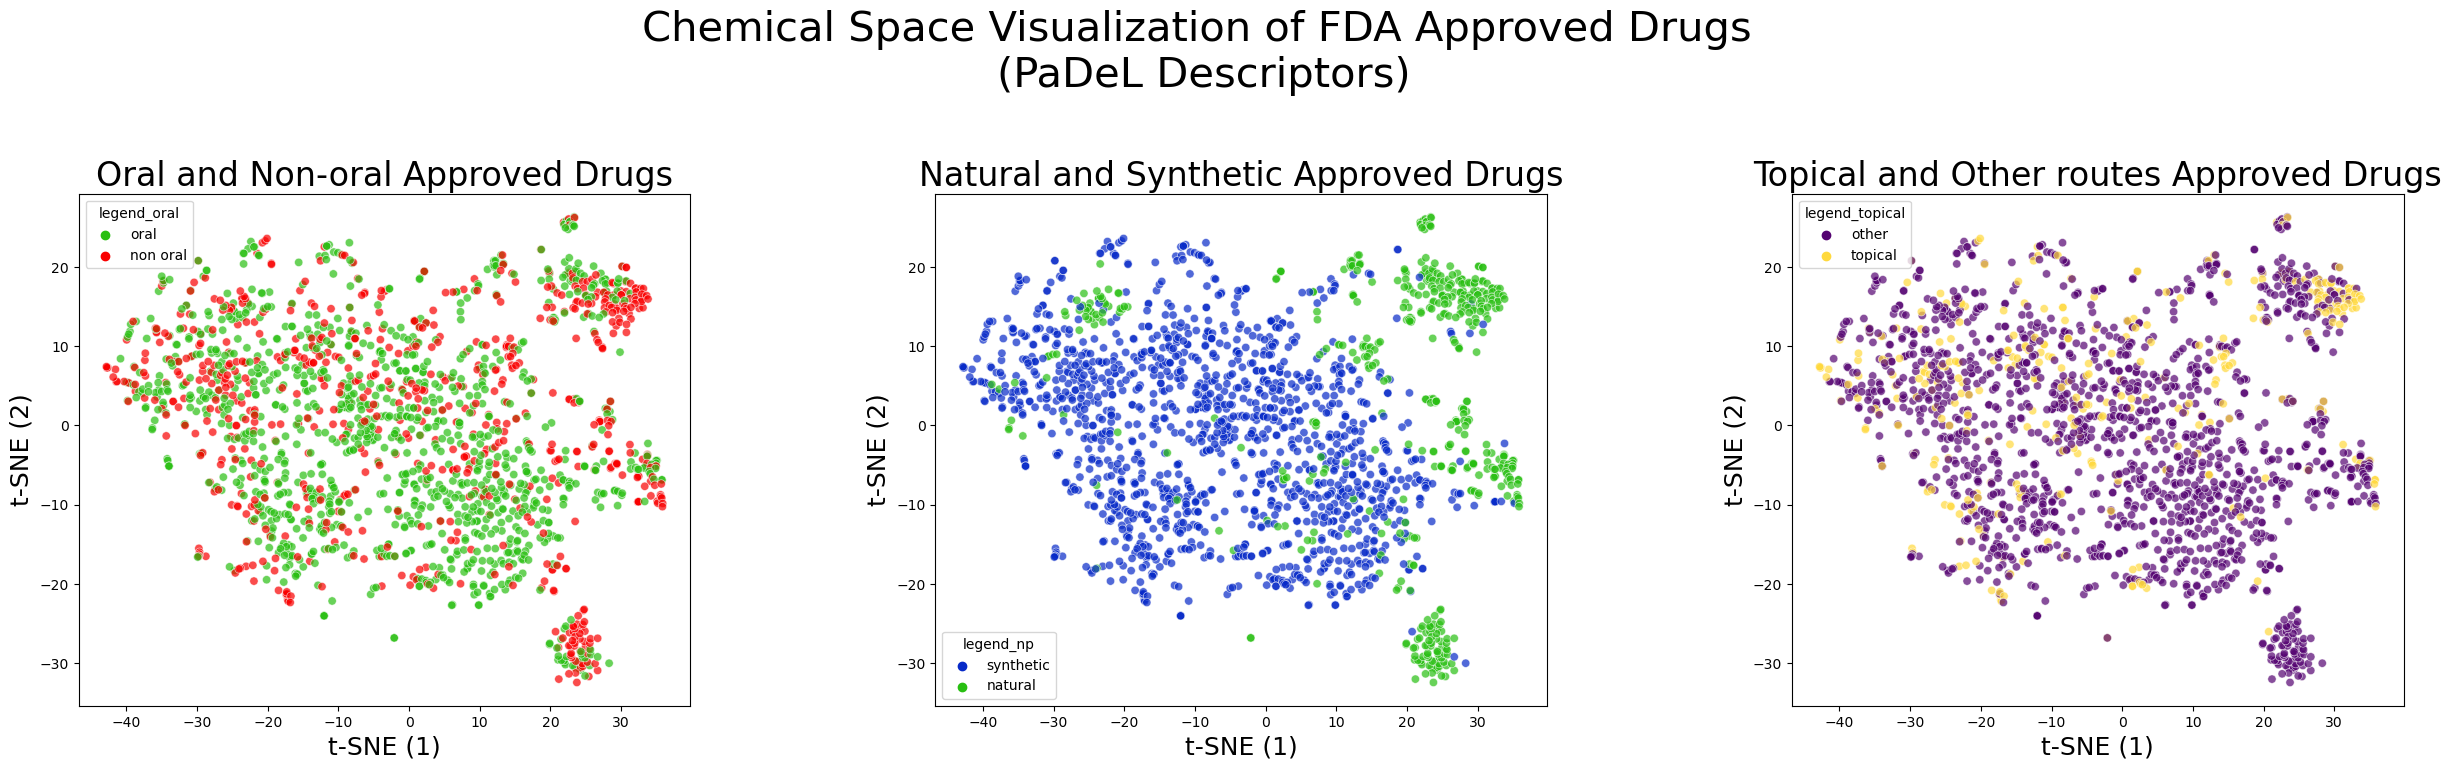

In [13]:
# t-SNE plots for oral/non-oral, natural/synthetic, topical/other
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
fig, axs = plt.subplots(1,3, figsize=(30,8))

palettes = {
    'oral': {'oral': '#29bf12', 'non oral': '#f90000'},
    'np': {'synthetic': '#072ac8', 'natural': '#28bf12'},
    'topical': {'topical': '#FFD93d', 'other':'#540371'}
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'np': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

# tsne plots
for i, category in enumerate(['oral', 'np', 'topical']):
    sns.scatterplot(data=tsne_df, x='tsne2d_1', y='tsne2d_2', hue=f'legend_{category}', ax=axs[i],
    palette=palettes[category], alpha=0.7)
    axs[i].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[i].set_xlabel('t-SNE (1)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[i].set_ylabel('t-SNE (2)', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
plt.subplots_adjust(wspace=0.4, top=0.75)
fig.suptitle('Chemical Space Visualization of FDA Approved Drugs \n(PaDeL Descriptors)', fontsize=30)